## About this notebook

*[Jigsaw Multilingual Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification)* is the 3rd annual competition organized by the Jigsaw team. It follows *[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)*, the original 2018 competition, and *[Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)*, which required the competitors to consider biased ML predictions in their new models. This year, the goal is to use english only training data to run toxicity predictions on many different languages, which can be done using multilingual models, and speed up using TPUs.

Many awesome notebooks has already been made so far. Many of them used really cool technologies like [Pytorch XLA](https://www.kaggle.com/theoviel/bert-pytorch-huggingface-starter). This notebook instead aims at constructing a **fast, concise, reusable, and beginner-friendly model scaffold**. It will focus on the following points:
* **Using Tensorflow and Keras**: Tensorflow is a powerful framework, and Keras makes the training process extremely easy to understand. This is especially good for beginners to learn how to use TPUs, and for experts to focus on the modelling aspect.
* **Using Huggingface's `transformers` library**: [This library](https://huggingface.co/transformers/) is extremely popular, so using this let you easily integrate the end result into your ML pipelines, and can be easily reused for your other projects.
* **Native TPU usage**: The TPU usage is abstracted using the native `strategy` that was created using Tensorflow's `tf.distribute.experimental.TPUStrategy`. This avoids getting too much into the lower-level aspect of TPU management.
* **Use a subset of the data**: Instead of using the entire dataset, we will only use the 2018 subset of the data available, which makes this much faster, all while achieving a respectable accuracy.

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score
batch_size = 8
warnings.simplefilter("ignore")

## Helper Functions

In [2]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [3]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. This is calculated as:
![](https://miro.medium.com/max/426/1*hub04IikybZIBkSEcEOtGA.png)

Cosine Similarity calculation for two vectors A and B [source]
With cosine similarity, we need to convert sentences into vectors. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency). The choice of TF or TF-IDF depends on application and is immaterial to how cosine similarity is actually performed — which just needs vectors. TF is good for text similarity in general, but TF-IDF is good for search query relevance.

In [4]:
# https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt') # if necessary...


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

[nltk_data] Downloading package punkt to /home/kb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## TPU Configs

In [5]:
# AUTO = tf.data.experimental.AUTOTUNE

# # Create strategy from tpu
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('kaggle/input/') 

## Create fast tokenizer

In [6]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('/kaggle/working/distilbert_base_uncased/vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=28996, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)

## Load text data into memory

In [7]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
# train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation_en.csv')
test1 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_en.csv')
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw_miltilingual_test_translated.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [8]:
test2.head()

,id,content,lang,translated
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr,Title named Doctor Who wiki 12. doctor has add...
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru,"It is possible, but I don't see the need to a..."
2,2,"Quindi tu sei uno di quelli conservativi , ...",it,"Then you're one of those conservative , who wo..."
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr,"Unfortunately, it was not performed, but had s..."
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr,:Resim:Seldabagcan.jpg the image of the source...


## Test dataset comparision

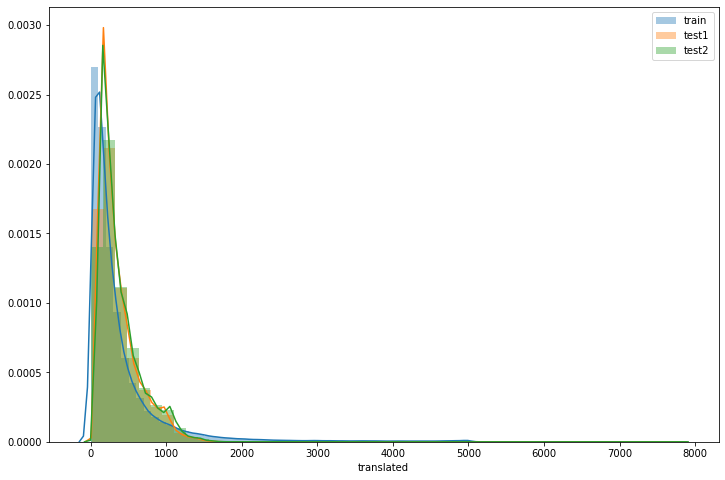

In [9]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.legend();

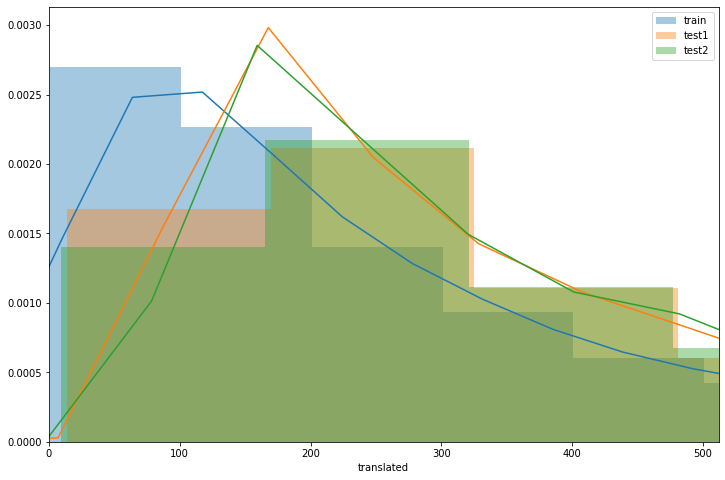

In [10]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.xlim([0, 512])
plt.legend();

Lets calculate cosine similarity two translated test datasets.

test_set_similarity = [cosine_sim(t1, t2) for t1, t2 in tqdm(zip(test1.content_en, test2.translated))]

plt.figure(figsize=(12, 8))

sns.distplot(test_set_similarity);

## Fast encode

In [11]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_valid = fast_encode(valid.comment_text_en.astype(str), fast_tokenizer, maxlen=512)
x_test1 = fast_encode(test1.content_en.astype(str), fast_tokenizer, maxlen=512)
x_test2 = fast_encode(test2.translated.astype(str), fast_tokenizer, maxlen=512)

y_train = train1.toxic.values
y_valid = valid.toxic.values

## Build datasets objects

In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(batch_size)
    #.prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(batch_size)
    .cache()
    #.prefetch(AUTO)
)

test_dataset = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(batch_size)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(batch_size)
)]

# Focal Loss

In [13]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Load model into the TPU

In [14]:
%%time
# with strategy.scope():
transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-cased')
model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 108310272 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 108,311,041
Trainable params: 108,311,041
Non-trainable params: 0
_________________________________________________________________
CPU times: user 3.24 s, sys: 298 ms, total: 3.54 s
Wall time: 4.54 s


## RocAuc Callback

In [15]:
from tensorflow.keras.callbacks import Callback 

class RocAucCallback(Callback):
    def __init__(self, test_data, score_thr):
        self.test_data = test_data
        self.score_thr = score_thr
        self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_auc'] > self.score_thr:
            print('\nRun TTA...')
            for td in self.test_data:
                self.test_pred.append(self.model.predict(td))

# LrScheduler

In [16]:
def build_lrfn(lr_start=0.000001, lr_max=0.000004, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
#     lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

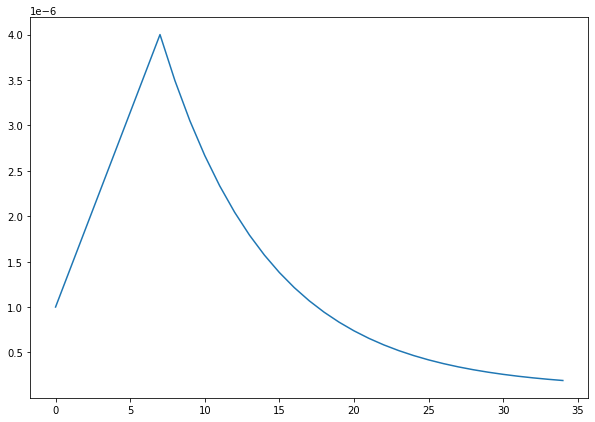

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)]);

## Train Model

### First Stage

In [ ]:
roc_auc = RocAucCallback(test_dataset, 0.935)
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=150,
    validation_data=valid_dataset,
    callbacks=[lr_schedule, roc_auc],
    epochs=35,
#     batch_size=16
)

Train for 150 steps, validate for 1000 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/35
150/150 [==============================] - 222s 1s/step - loss: 0.0544 - auc: 0.5413 - val_loss: 0.0579 - val_auc: 0.5760

Epoch 00002: LearningRateScheduler reducing learning rate to 1.4285714285714286e-06.
Epoch 2/35
150/150 [==============================] - 208s 1s/step - loss: 0.0439 - auc: 0.5311 - val_loss: 0.0480 - val_auc: 0.6199

Epoch 00003: LearningRateScheduler reducing learning rate to 1.857142857142857e-06.
Epoch 3/35
 22/150 [===>..........................] - ETA: 52s - loss: 0.0317 - auc: 0.7774

In [ ]:
# model.fit?

### Second Stage

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

lrfn = build_lrfn(lr_start=0.000001, lr_max=0.0000005, 
               lr_min=0.0000001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.87)
plt.plot([i for i in range(25)], [_lrfn(i) for i in range(25)]);

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_valid, y_valid, test_size=0.15, shuffle=True, random_state=123, stratify=y_valid)

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(64)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(64)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=75,
    validation_data=valid_dataset,
    callbacks=[lr_schedule, roc_auc],
    epochs=25
)

## Submission

In [ ]:
sub['toxic'] = np.mean(roc_auc.test_pred, axis=0)
sub.to_csv('submission.csv', index=False)

# Reference
* [Jigsaw TPU: DistilBERT with Huggingface and Keras](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)
* [inference of bert tpu model ml w/ validation](https://www.kaggle.com/abhishek/inference-of-bert-tpu-model-ml-w-validation)
* [Overview of Text Similarity Metrics in Python](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50)
* [test-en-df](https://www.kaggle.com/bamps53/test-en-df)
* [val_en_df](https://www.kaggle.com/bamps53/val-en-df)
* [Jigsaw multilingual toxic - test translated](https://www.kaggle.com/kashnitsky/jigsaw-multilingual-toxic-test-translated)